In [1]:
import os
import pickle
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import torch
import torchvision
from diffusers import StableDiffusionPipeline
from transformers import CLIPProcessor, CLIPModel
from transformers import BlipProcessor, BlipForConditionalGeneration

In [2]:
model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"


pipe = StableDiffusionPipeline.from_pretrained(model_id)
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 58.00 MiB. GPU 0 has a total capacity of 3.71 GiB of which 52.38 MiB is free. Including non-PyTorch memory, this process has 3.64 GiB memory in use. Of the allocated memory 3.51 GiB is allocated by PyTorch, and 74.06 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
height = 512
width = 512
num_inference_steps = 50
guidance_scale = 0
generator = torch.manual_seed(1024)
batch_size = 1

In [5]:
f_name = "datum.pickle"
with open(f_name, "rb") as f:
  data = pickle.load(f)
  vals_to_return = [data["stim"], data["resp"]]

In [59]:
f_name = "output_train.pickle"
with open(f_name, "rb") as f:
  data = pickle.load(f)

latent_vec_train_pred = torch.from_numpy(data.reshape(-1, 4, 64, 64)).to(device)

In [ ]:
f_name = "output_vae_val.pickle"
with open(f_name, "rb") as f:
  data = pickle.load(f)

latent_vec_val_pred = torch.from_numpy(data[0].reshape(-1, 4, 64, 64)).to(device)
latent_vec_val_true = torch.from_numpy(data[1].reshape(-1, 4, 64, 64)).to(device)

In [ ]:
f_name = "output_clip_val.pickle"
with open(f_name, "rb") as f:
  data = pickle.load(f)

clip_val_pred = torch.from_numpy(data[0].reshape(-1, 12, 768)).to(device)
clip_val_true = torch.from_numpy(data[1].reshape(-1, 12, 768)).to(device)

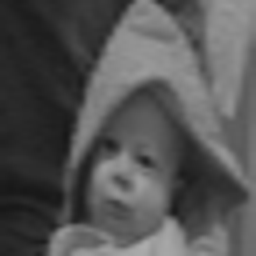

In [12]:
img = torchvision.transforms.functional.to_pil_image(vals_to_return[0]).resize((36, 64)).resize((256, 256))
display(img)

In [ ]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

In [12]:
blip_transform = torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(),
            torchvision.transforms.Resize((512, 512))
        ])

# Generate captions (use beam search or greedy decoding to get the most likely caption)
with torch.no_grad():
    blip_image_tensor = blip_transform(vals_to_return[0])
    blip_preprocessed = processor(images=blip_image_tensor, return_tensors="pt")
    caption_ids = model.generate(**blip_preprocessed, max_length=50)
    caption = processor.decode(caption_ids[0], skip_special_tokens=True)
print(caption)

a baby in a hat and coat


In [6]:
def pil_to_latent(input_image):
    # turn single image into a latent in a batch
    with torch.no_grad():
        # use pre-trained vae to convert to tensor
        # unsqueeze: add a single dimension of size 1 at beginning
        # normalize pixel values to between -1 and 1
        latent = pipe.vae.encode(torchvision.transforms.ToTensor()(input_image.convert("RGB")).unsqueeze(0).to(device)*2 - 1)

    # scale factor from https://arxiv.org/pdf/2112.10752
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # reverse scaling
    latents = (1/0.18215) * latents
    with torch.no_grad():
        # decode sample
        image = pipe.vae.decode(latents).sample

    # normalize, shift from -1 and 1 to 0 to 1 and clamp values in that range
    image = (image / 2 + 0.5).clamp(0, 1)

    # permute used to convert tensor to image, with channels as last dimension
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()

    # convert to format expected by PIL images (scale to 255, round, convert to unsigned 8 bit integers)
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [ ]:
img = Image.fromarray(np.random.randint(0,255,(512, 512, 3),dtype=np.dtype('uint8')))

In [13]:
latent_vector = pil_to_latent(img)

In [15]:
latent_vector.shape

torch.Size([1, 4, 32, 32])

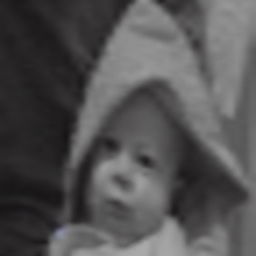

In [14]:
recon_img = latents_to_pil(latent_vector)[0]
display(recon_img.resize((256, 256)))

In [13]:
text_input = pipe.tokenizer(
    caption,
    padding = "max_length",
    max_length = pipe.tokenizer.model_max_length,
    truncation = True,
    return_tensors = "pt" # pt stands for pytorch :)
)
with torch.no_grad():
    text_embeddings = pipe.text_encoder(text_input.input_ids.to(device)).last_hidden_state
    # gradients don't need to be updated during image generation; this saves computational resources

# uncond_input is random noise with the same shape as the text input
max_length = text_input.input_ids.shape[-1] # anchored to the text input/prompt
uncond_input = pipe.tokenizer(
    [""] * 1, # depending on # of batches of text, this could be expanded
    padding = "max_length",
    max_length = pipe.tokenizer.model_max_length,
    return_tensors = "pt" # pt stands for pytorch
)
with torch.no_grad():
    uncond_embeddings = pipe.text_encoder(uncond_input.input_ids.to(device)).last_hidden_state

# concatenate the 2 embeddings to get an "average" to avoid being too specific
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [62]:
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    #scheduler.timesteps = scheduler.timesteps.to(torch.float32)

set_timesteps(pipe.scheduler, num_inference_steps)

In [82]:
latent_vector = latent_vec_train_pred.clone()

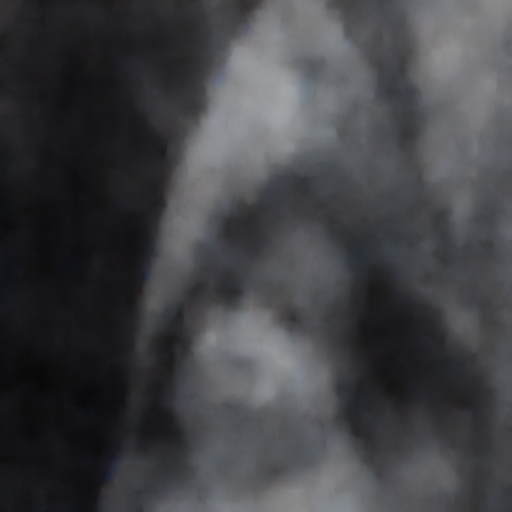

In [89]:
start_step = 48
noise = torch.randn_like(latent_vector)
latents = pipe.scheduler.add_noise(
    latent_vector,
    noise,
    timesteps = torch.tensor([pipe.scheduler.timesteps[start_step]])
)
latents = latents.to(device)

display(latents_to_pil(latents)[0])

In [90]:
for i, t in tqdm(enumerate(pipe.scheduler.timesteps), total = len(pipe.scheduler.timesteps)):
    if i >= start_step: # start after step 10 since we already added noise

        # expand latents if doing cfg
        latent_model_input = torch.cat([latents] * 2)
        #sigma = pipe.scheduler.sigmas[i]

        # scale latents (preconditioning)
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        # predict noise residual using unet
        with torch.no_grad():
            noise_pred = pipe.unet(
                latent_model_input,
                t,
                encoder_hidden_states = text_embeddings
            )["sample"]

        # perform guidance based on scale to which prompt should tip
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute previous noisy sample
        latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

100%|██████████| 51/51 [00:01<00:00, 47.23it/s]


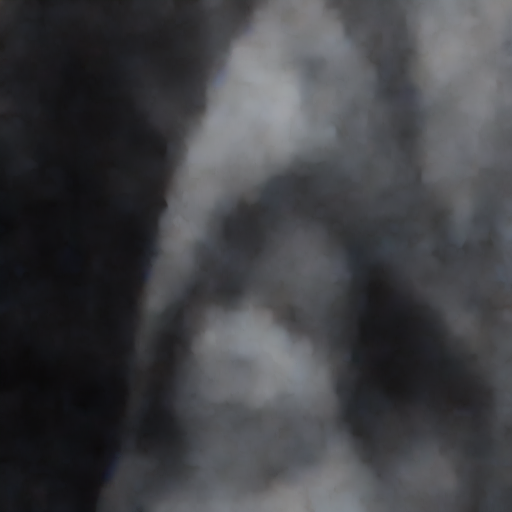

In [91]:
display(latents_to_pil(latents)[0])